In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""

"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
#from random_forest import random_forest
import scipy.stats as ss

df = pd.read_csv("RF_results.csv")
T=df['Y_rf'].shape[0]

Y_rf = np.asarray(df['Y_rf'])
Y = np.asarray(df['Y'])
Y_close = np.asarray(df['Y_close'])

In [2]:
df.head()

,Y,Y_rf,Y_close
0,805.46,805.415755,813.50
1,814.42,812.103375,824.85
2,826.68,813.081059,827.18
3,828.00,823.485781,826.50
4,826.50,825.892998,829.98


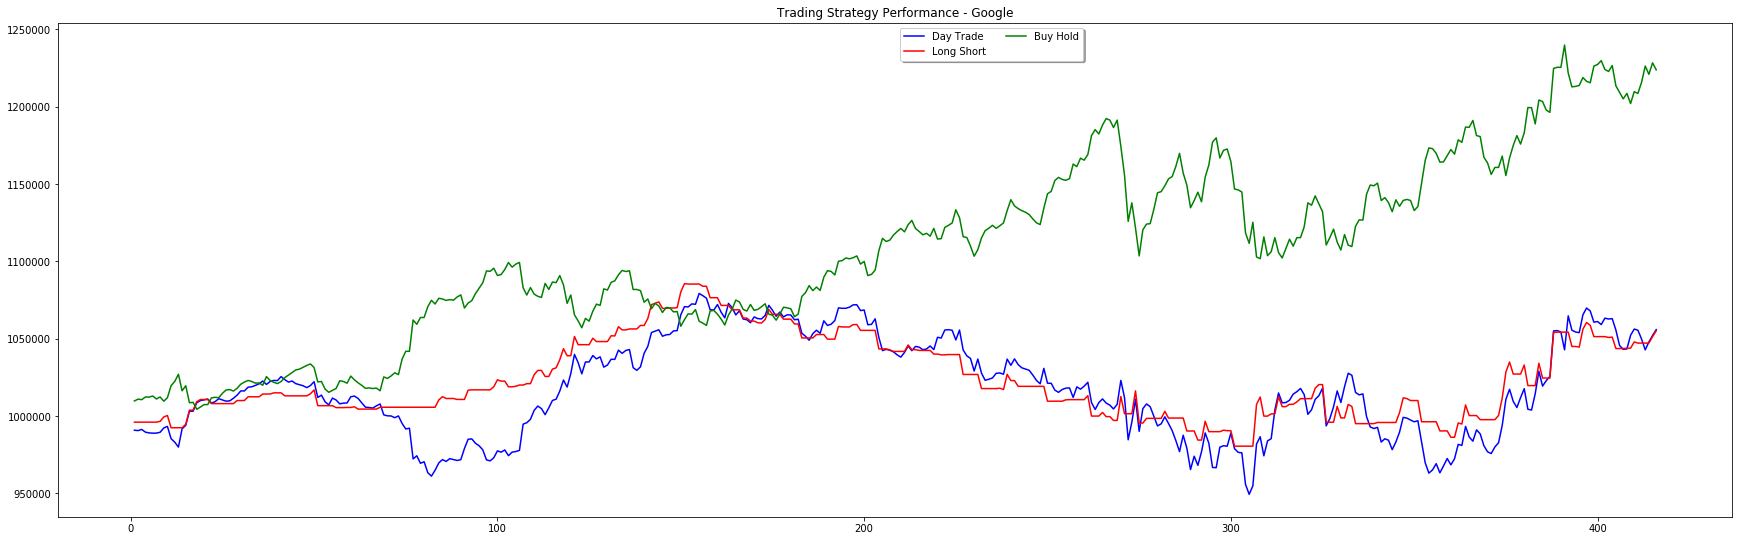

In [3]:
"trading rule 1: day trade"
signal_rule1 =  np.zeros(T)
for t in range(0, T):
    if Y_rf[t] > Y[t]:
        signal_rule1[t] = 1  # long signal
    elif Y_rf[t] < Y[t]:
        signal_rule1[t] = -1  # short signal
        
pos_rule1 = signal_rule1 # open and close position every day

"trading rule 2: long short"
signal_rule2 = np.zeros(T)
pos_rule2 = np.zeros(T)
for t in range(0, T):
    if Y_rf[t] > Y[t]:
        signal_rule2[t] = 1  
    elif Y_rf[t] < Y[t]:
        signal_rule2[t] = -1  

for t in range(0, T):
    if t==0:
        pos_rule2[t] = signal_rule2[t]
    elif signal_rule2[t] != signal_rule2[t-1]: 
        # take the first long/short signal as position
        pos_rule2[t] = signal_rule2[t] 
  
"trading rule 3: buy hold"
signal_rule3 =  np.zeros(T)
pos_rule3 = np.zeros(T)
for t in range(0, T):
    if t==0:
        signal_rule3[t] = 1  
    else:
        signal_rule3[t] =  -1

pos_rule3 = signal_rule3


"account balances"

init_bal = 1000000 #initial account balance
num_shares = 500 # number of shares being traded in one position


balance_rule1= np.zeros(T)
balance_rule2= np.zeros(T)
balance_rule3= np.zeros(T)

temp_bal1 = init_bal
temp_bal2 = init_bal
temp_bal3 = init_bal
for t in range(0,T):  
    # day trade
    balance_rule1[t] = temp_bal1 - pos_rule1[t]*num_shares*Y[t] + pos_rule1[t]*num_shares*Y_close[t]
    temp_bal1 = balance_rule1[t]
    
    # long short
    balance_rule2[t] = temp_bal2 - pos_rule2[t]*num_shares*Y[t] + pos_rule2[t]*num_shares*Y_close[t]
    temp_bal2 = balance_rule2[t]  
    # buy hold
    if t==0:
        # initially hold long position and not close it
        balance_rule3[t] = temp_bal3 - pos_rule3[t]*num_shares*Y[t]  
        temp_bal3 = balance_rule3[t]
    else:
        # closing initial position at time t, aka holdig it for t-1 days
        balance_rule3[t] = temp_bal3 + pos_rule3[0]*num_shares*Y_close[t] 

    
    
# plot account balance
timevec = np.linspace(1,T-1,T-1)
plt.figure(figsize=(30,20))

ax1 = plt.subplot(211)
ax1.plot(timevec, balance_rule1[1:], 'blue', label = "Day Trade")
ax1.plot(timevec, balance_rule2[1:], 'red', label = "Long Short")
ax1.plot(timevec, balance_rule3[1:], 'green', label = "Buy Hold")
ax1.legend(loc=2, bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
plt.title('Trading Strategy Performance - Google')
plt.show()

In [4]:
# save to dataframe
combined = np.stack([Y, Y_rf, signal_rule1, pos_rule1, balance_rule1, 
                     signal_rule2, pos_rule2, balance_rule2,   
                     signal_rule3, pos_rule3, balance_rule3,Y_close], axis = 1)
df1 = pd.DataFrame(combined, index=np.arange(0,T), 
                  columns=['Y','Y_RF','sig_1','pos_1','bal_1',
                           'sig_2','pos_2','bal_2',
                           'sig_3','pos_3','bal_3','Y_close'])

df1['PL1'] = df1.bal_1 - df1.bal_1.shift(1)
df1['PL2'] = df1.bal_2 - df1.bal_2.shift(1)
df1['PL3'] = df1.bal_3 - df1.bal_3.shift(1)

df1.to_csv('trades.csv')

In [5]:
df1.head()

,Y,Y_RF,sig_1,pos_1,bal_1,sig_2,pos_2,bal_2,sig_3,pos_3,bal_3,Y_close,PL1,PL2,PL3
0,805.46,805.415755,-1.0,-1.0,995980.0,-1.0,-1.0,995980.0,1.0,1.0,597270.0,813.50,NaN,NaN,NaN
1,814.42,812.103375,-1.0,-1.0,990765.0,-1.0,0.0,995980.0,-1.0,-1.0,1009695.0,824.85,-5215.0,0.0,412425.0
2,826.68,813.081059,-1.0,-1.0,990515.0,-1.0,0.0,995980.0,-1.0,-1.0,1010860.0,827.18,-250.0,0.0,1165.0
3,828.00,823.485781,-1.0,-1.0,991265.0,-1.0,0.0,995980.0,-1.0,-1.0,1010520.0,826.50,750.0,0.0,-340.0
4,826.50,825.892998,-1.0,-1.0,989525.0,-1.0,0.0,995980.0,-1.0,-1.0,1012260.0,829.98,-1740.0,0.0,1740.0


In [6]:
df1['PL1'][0] = df1['bal_1'][0] - 1000000 
df1['PL2'][0] = df1['bal_2'][0] - 1000000
df1['PL3'][0] = df1['bal_3'][0] - 1000000

C:\Users\surak\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in double_scalars


+----------------------------+----------------------+
|   Results Of Day Trading   |        Values        |
+----------------------------+----------------------+
|   Number of trading days   |         417          |
|        Total profit        |       960105.0       |
|         Total loss         |       904280.0       |
|          Profit%           |        5.5825        |
|        Profit Days         |         216          |
|         Loss Days          |         201          |
| Aver net profit per trade: |  133.8729016786571   |
|     Aver daily return      |  1.7805550239234451  |
|      Daily return std      |  3.0946452064671592  |
|   Daily return skewness    | 0.09962629182602009  |
|   Daily return kurtosis    | -1.0071051867537906  |
|        Sharpe ratio        | -0.0709111906004478  |
|       Sortino ratio        | -0.19983660398587344 |
+----------------------------+----------------------+


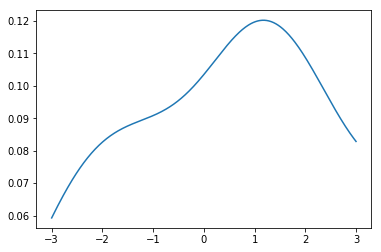

+----------------------------+---------------------+
|   Results Of Long Short    |        Values       |
+----------------------------+---------------------+
|   Number of trading days   |         417         |
|        Total profit        |       466990.0      |
|         Total loss         |       411940.0      |
|          Profit%           |        5.505        |
|        Profit Days         |         335         |
|         Loss Days          |          82         |
| Aver net profit per trade: |  1314.5443645083933 |
|     Aver daily return      |  2.305003588516746  |
|      Daily return std      |  2.555457822934226  |
|   Daily return skewness    |  0.5677923194403979 |
|   Daily return kurtosis    | -0.7850180972938037 |
|        Sharpe ratio        |  0.1193537947601636 |
|       Sortino ratio        |  0.5981734774613762 |
+----------------------------+---------------------+


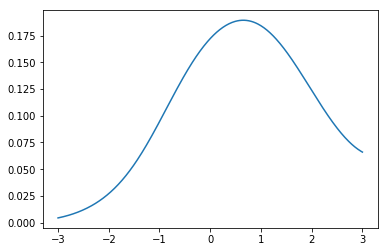

+----------------------------+---------------------+
|    Results Of Buy Hold     |        Values       |
+----------------------------+---------------------+
|   Number of trading days   |         417         |
|        Total profit        |      1514060.0      |
|         Total loss         |      1290290.0      |
|          Profit%           |        22.377       |
|        Profit Days         |         230         |
|         Loss Days          |         187         |
| Aver net profit per trade: |  -791.810551558753  |
|     Aver daily return      |  10.448206937799045 |
|      Daily return std      |   6.40281491416078  |
|   Daily return skewness    | -1.0126492413029986 |
|   Daily return kurtosis    |  8.058669908094243  |
|        Sharpe ratio        |  1.319451999012899  |
|       Sortino ratio        |         inf         |
+----------------------------+---------------------+


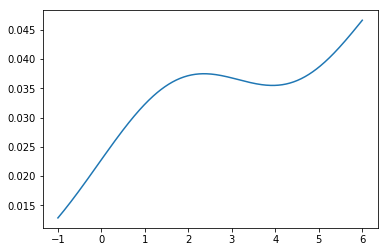

In [7]:
"analytics: profit and loss, ratios, etc"

# daily profit and loss
profit_loss1 =  df1.PL1.sum()

profit_loss2 =  df1.PL2.sum()

profit_loss3 =  df1.PL3.sum()


balance_rule1 = np.insert(balance_rule1, 0, init_bal)

balance_rule2 = np.insert(balance_rule2, 0, init_bal)

balance_rule3 = np.insert(balance_rule3, 0, init_bal)

total_profit1 = sum(x for x in df1.PL1 if x>0)    
total_loss1 = abs(sum(x for x in df1.PL1 if x<0))

cnt_profit1 = 0
cnt_loss1 = 0
for num in df1.PL1: 
    if num >= 0: 
        cnt_profit1 += 1
    else: 
        cnt_loss1 += 1
        

total_profit2 = sum(x for x in df1.PL2 if x>0)    
total_loss2 = abs(sum(x for x in df1.PL2 if x<0))

cnt_profit2 = 0
cnt_loss2 = 0
for num in df1.PL2: 
    if num >= 0: 
        cnt_profit2 += 1
    else: 
        cnt_loss2 += 1


total_profit3 = sum(x for x in df1.PL3 if x>0)    
total_loss3 = abs(sum(x for x in df1.PL3 if x<0))
cnt_profit3 = 0
cnt_loss3 = 0
for num in df1.PL3: 
    if num >= 0: 
        cnt_profit3 += 1
    else: 
        cnt_loss3 += 1


# daily return in percentage
return1 = (balance_rule1 - init_bal)/init_bal*100
return2 = (balance_rule2 - init_bal)/init_bal*100
return3 = (balance_rule3 - init_bal)/init_bal*100


# ratios, assuming 3 month T bill rate around 2%
sharpe1 = (np.mean(return1) - 2)/np.std(return1-2)
sharpe2 = (np.mean(return2) - 2)/np.std(return2-2)
sharpe3 = (np.mean(return3) - 2)/np.std(return3-2)
sortino1 =(np.mean(return1) - 2)/np.std([x for x in return1 if x<0])
sortino2 =(np.mean(return2) - 2)/np.std([x for x in return2 if x<0])
sortino3 =(np.mean(return3) - 2)/np.std([x for x in return3 if x<0])






        
t = PrettyTable(['Results Of Day Trading', 'Values'])
t.add_row(['Number of trading days', T])
t.add_row(['Total profit', total_profit1])
t.add_row(['Total loss',total_loss1])
t.add_row(['Profit%',(profit_loss1/init_bal)*100])
t.add_row(['Profit Days',cnt_profit1])
t.add_row(['Loss Days',cnt_loss1])
t.add_row(['Aver net profit per trade:', (total_profit1-total_loss1)/T])
t.add_row(['Aver daily return',np.mean(return1)])
t.add_row(['Daily return std', np.std(return1)])
t.add_row(['Daily return skewness', ss.skew(return1)])
t.add_row(['Daily return kurtosis', ss.kurtosis(return1)])
t.add_row(['Sharpe ratio', sharpe1])
t.add_row(['Sortino ratio', sortino1])
print(t)



den = ss.gaussian_kde(return1) 
xs = np.linspace(-3,3,400)
plt.plot(xs,den(xs))
plt.show()


t = PrettyTable(['Results Of Long Short', 'Values'])
t.add_row(['Number of trading days', T])
t.add_row(['Total profit', total_profit2])
t.add_row(['Total loss',total_loss2])
t.add_row(['Profit%',(profit_loss2/init_bal)*100])
t.add_row(['Profit Days',cnt_profit2])
t.add_row(['Loss Days',cnt_loss2])
t.add_row(['Aver net profit per trade:', (total_profit1-total_loss2)/T])
t.add_row(['Aver daily return',np.mean(return2)])
t.add_row(['Daily return std', np.std(return2)])
t.add_row(['Daily return skewness', ss.skew(return2)])
t.add_row(['Daily return kurtosis', ss.kurtosis(return2)])
t.add_row(['Sharpe ratio', sharpe2])
t.add_row(['Sortino ratio', sortino2])
print(t)




den = ss.gaussian_kde(return2) 
xs = np.linspace(-3,3,400)
plt.plot(xs,den(xs))
plt.show()


t = PrettyTable(['Results Of Buy Hold', 'Values'])
t.add_row(['Number of trading days', T])
t.add_row(['Total profit', total_profit3])
t.add_row(['Total loss',total_loss3])
t.add_row(['Profit%',(profit_loss3/init_bal)*100])
t.add_row(['Profit Days',cnt_profit3])
t.add_row(['Loss Days',cnt_loss3])
t.add_row(['Aver net profit per trade:', (total_profit1-total_loss3)/T])
t.add_row(['Aver daily return',np.mean(return3)])
t.add_row(['Daily return std', np.std(return3)])
t.add_row(['Daily return skewness', ss.skew(return3)])
t.add_row(['Daily return kurtosis', ss.kurtosis(return3)])
t.add_row(['Sharpe ratio', sharpe3])
t.add_row(['Sortino ratio', sortino3])
print(t)


den = ss.gaussian_kde(return3) 
xs = np.linspace(-1,6,400)
plt.plot(xs,den(xs))
plt.show()